In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
#from collections import Counter
#import sys
#from multiprocessing import cpu_count
import seaborn as sns


pd.set_option('display.max_rows', 20) # default: 60
pd.set_option('display.max_info_columns', 10)
pd.set_option('display.max_colwidth', 120) # default: 50
pd.set_option('display.precision', 3) # default: 6
pd.set_option('display.expand_frame_repr', True) # default: True
pd.set_option('display.width', 100) # default: 80



from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn import svm, datasets, ensemble, metrics
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale

from sklearn.datasets import load_digits
import umap.umap_ as umap

/Users/kateryna/opt/anaconda3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
%matplotlib inline

In [3]:
df = pd.DataFrame()

for folder in glob.glob("/work/jrc_combine/ASIC/kalibrierungsdaten/features/*")
    df_current = pd.read_csv(f"{folder}/baseline_values.csv", index_col = 0)
    df_current.encounterid = df_current.encounterid.astype(int)
    df_current.set_index("encounterid", drop = True, inplace = True)
    df_current.sort_index(inplace = True)
    df_current["uka"] = int(re.search(".*([0-9]+)", folder).group(1))
    df = pd.concat([df, df_current], ignore_index=True)
    
df = df.groupby('uka').apply(lambda x: x.sample(n=df.uka.value_counts().min())).reset_index(drop = True)

In [4]:
label = df["uka"]

In [5]:
cols = pd.read_feather("./PCA/checked_params_wo_vtspont.feather")

In [6]:
baseline_cols = ["baseline_"+col for col in cols['names'].values]+ \
                    ["baseline_"+i for i in ["FiO2", "etCO2", "paO2_(ohne_Temp-Korrektur)", "ZVD", "MPAP", "Lymphozyten_prozentual", "LDH"]]

In [7]:
df = df[baseline_cols]

In [8]:
df = df[df.columns[df.count() > len(df)*0.7]]

In [9]:
df = df.fillna(df.median())

In [10]:
df_scaled = pd.DataFrame(scale(df), columns = df.columns)

In [11]:
pca = PCA(n_components=len(df.columns))
pca.fit(df_scaled)

df_pca = pca.fit_transform(df_scaled)

clus_s = df.shape
print("t-SNE... ({} points, {} source dimensions)".format(clus_s[0], clus_s[1]))
tsne = TSNE(n_components=2)  # n_components should be set to 2 for 2d plotting
features_embedded = tsne.fit_transform(df_scaled)
print("Done fitting.")

t-SNE... (4092 points, 20 source dimensions)
Done fitting.


2


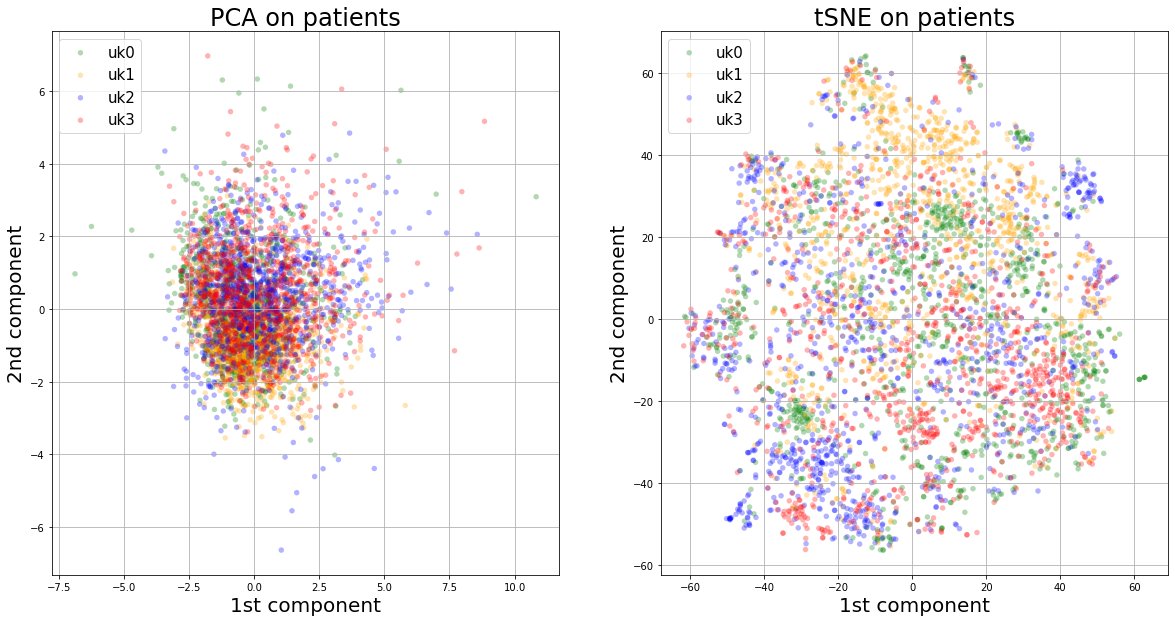

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (20,10))
print(len(axs))


colors = ("green", "orange", "blue", "red")
groups = ("uk0", "uk1", "uk2", "uk3") 


for i, color, group in zip(np.unique(label), colors, groups):
        axs[0].scatter(df_pca[(label == i)][:, 0], df_pca[(label == i)][:, 1],
                   alpha=0.3, c=color, edgecolors='none', s=30, label=group)
    

axs[0].set_title('PCA on patients', size = 24)
axs[0].set_xlabel('1st component', size = 20)
axs[0].set_ylabel('2nd component', size = 20)
axs[0].legend(loc=2, fontsize = 15)
axs[0].grid()


# kmeans clustering

for i, color, group in zip(np.unique(label), colors, groups):
        axs[1].scatter(features_embedded[(label == i)][:, 0], features_embedded[(label == i)][:, 1],
                   alpha=0.3, c=color, edgecolors='none', s=30, label=group)
    

axs[1].set_title('tSNE on patients', size = 24)
axs[1].set_xlabel('1st component', size = 20)
axs[1].set_ylabel('2nd component', size = 20)
axs[1].legend(loc=2, fontsize = 15)
axs[1].grid()

plt.show()

In [13]:
#PCA
df_pca_plot = pd.DataFrame(df_pca)
df_pca_plot["uka"]=label.values

In [14]:
#tSNE
features_embedded_plot=pd.DataFrame(features_embedded)
features_embedded_plot["uka"]=label.values

Text(0.5, 1.0, 'tSNE')

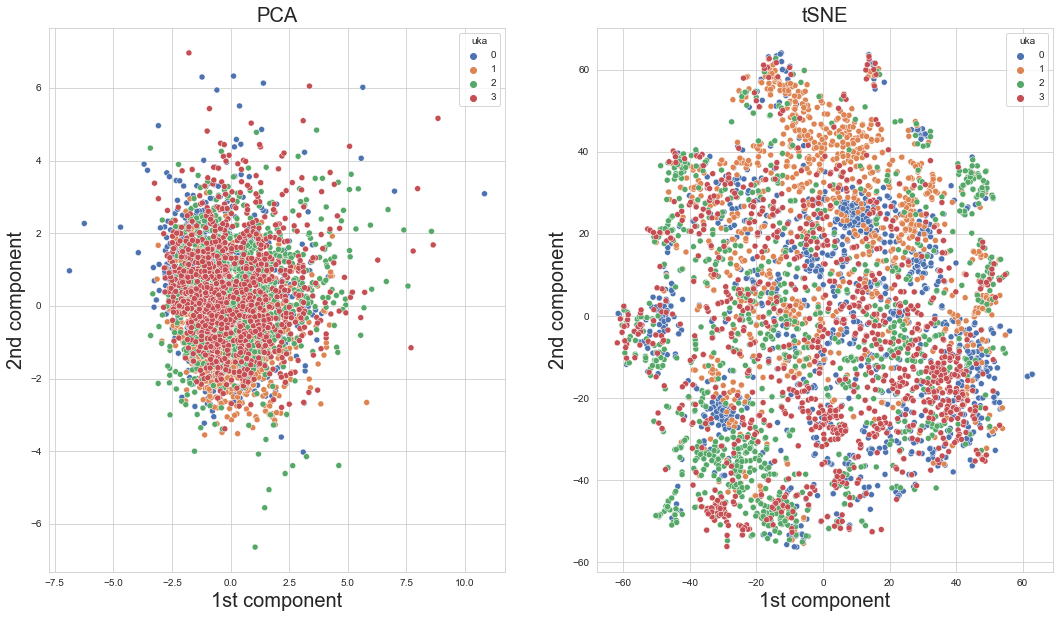

In [15]:
sns.set_style(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18,10))
#PCA
sns.scatterplot(ax=axes[0], data=df_pca_plot, x=df_pca_plot.iloc[:,0], y=df_pca_plot.iloc[:,1], hue='uka', palette="deep")
axes[0].set_xlabel('1st component', size = 20)
axes[0].set_ylabel('2nd component', size = 20)
axes[0].set_title("PCA", size=20)
#tSNE
sns.scatterplot(ax=axes[1], data=features_embedded_plot, x=features_embedded_plot.iloc[:,0], y=features_embedded_plot.iloc[:,1], hue='uka', palette="deep")
axes[1].set_xlabel('1st component', size = 20)
axes[1].set_ylabel('2nd component', size = 20)
axes[1].set_title("tSNE", size=20)

## UMAP

In [16]:
reducer = umap.UMAP()

In [17]:
embedding = reducer.fit_transform(df_scaled)

In [18]:
embedding_df = pd.DataFrame(embedding, columns=["1st_comp", "2nd_comp"])

In [19]:
embedding_df["uka"]=label.values

Text(0.5, 1.0, 'UMAP')

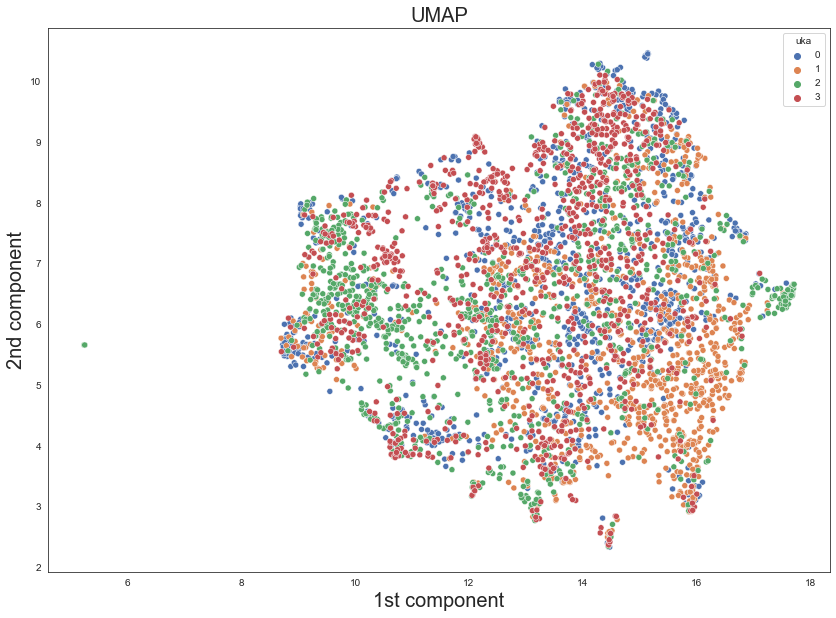

In [20]:
sns.set_style(style='white')#, rc={'figure.figsize':(20,16)})
fig, ax = plt.subplots(figsize = (14,10))

sns.scatterplot(ax=ax, data=embedding_df, x='1st_comp', y='2nd_comp', hue='uka', palette="deep")
ax.set_xlabel('1st component', size = 20)
ax.set_ylabel('2nd component', size = 20)
ax.set_title("UMAP", size=20)